In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    scaler = StandardScaler()

    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y) ("hysteresis")
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_test = scaler.transform(X_test.values)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [5]:
class fourNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(fourNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [6]:
!pip install torchmetrics

In [7]:
from torch import tensor
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer,train_set,target,val_set,val_target):
  criterion = nn.MSELoss()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(train_set)
      loss = criterion(outputs, target)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

      model.eval()  # Set the model to evaluation mode
      with torch.no_grad():  # Disable gradient calculation for validation
          val_outputs = model(val_set)
          val_loss = criterion(val_outputs, val_target)
          if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Val_Loss: {val_loss}')

def test(model,data):
  model.eval()
  criterion_MSE = nn.MSELoss()
  criterion_MAE = nn.L1Loss()
  criterion_MAPE = MeanAbsolutePercentageError()
  with torch.no_grad():
      predicted = model(data[0])
      test_loss_MSE = criterion_MSE(predicted, data[1])
      test_loss_MAE = criterion_MAE(predicted, data[1])
      test_loss_MAPE = criterion_MAPE(predicted, data[1])
      print(f'MSE Test Loss: {test_loss_MSE.item():.4f}')
      print(f'MAE Test Loss: {test_loss_MAE.item():.4f}')
      print(f'MAPE Test Loss: {test_loss_MAPE.item():.4f}')
  return predicted

In [8]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/V'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')


Separando os "targets"

In [9]:
histeresis_train_tensor = [pair[0].item() for pair in y_train_tensor]
histeresis_train_tensor = torch.tensor(histeresis_train_tensor, dtype=torch.float32)
histeresis_train_tensor = histeresis_train_tensor.unsqueeze(1)

joule_train_tensor = [pair[1].item() for pair in y_train_tensor]
joule_train_tensor = torch.tensor(joule_train_tensor, dtype=torch.float32)
joule_train_tensor = joule_train_tensor.unsqueeze(1)

histeresis_val_tensor = [pair[0].item() for pair in y_val_tensor]
histeresis_val_tensor = torch.tensor(histeresis_val_tensor, dtype=torch.float32)
histeresis_val_tensor = histeresis_val_tensor.unsqueeze(1)

joule_val_tensor = [pair[1].item() for pair in y_val_tensor]
joule_val_tensor = torch.tensor(joule_val_tensor, dtype=torch.float32)
joule_val_tensor = joule_val_tensor.unsqueeze(1)

histeresis_test_tensor = [pair[0].item() for pair in y_test_tensor]
histeresis_test_tensor = torch.tensor(histeresis_test_tensor, dtype=torch.float32)
histeresis_test_tensor = histeresis_test_tensor.unsqueeze(1)

joule_test_tensor = [pair[1].item() for pair in y_test_tensor]
joule_test_tensor = torch.tensor(joule_test_tensor, dtype=torch.float32)
joule_test_tensor = joule_test_tensor.unsqueeze(1)

criando modelos para teste


In [10]:
input_size = X_train_tensor.shape[1]
print(input_size)

modelN_hysteresis = fourNetwork(input_size, 1)
modelN_joule = fourNetwork(input_size, 1)
modelN_total = fourNetwork(input_size, 2)

optimizer_h = optim.Adam(modelN_hysteresis.parameters(), lr=0.001)
optimizer_j = optim.Adam(modelN_joule.parameters(), lr=0.001)
optimizer_t = optim.Adam(modelN_total.parameters(), lr=0.001)

6


Testes para "histeresis"

In [11]:
train(modelN_hysteresis,50000,optimizer_h,X_train_tensor, histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)

Epoch [100/50000], Loss: 0.0277
Epoch [100/50000], Val_Loss: 0.028281163424253464
Epoch [200/50000], Loss: 0.0208
Epoch [200/50000], Val_Loss: 0.021957367658615112
Epoch [300/50000], Loss: 0.0189
Epoch [300/50000], Val_Loss: 0.02042383700609207
Epoch [400/50000], Loss: 0.0181
Epoch [400/50000], Val_Loss: 0.0196938868612051
Epoch [500/50000], Loss: 0.0177
Epoch [500/50000], Val_Loss: 0.019287314265966415
Epoch [600/50000], Loss: 0.0174
Epoch [600/50000], Val_Loss: 0.019123230129480362
Epoch [700/50000], Loss: 0.0176
Epoch [700/50000], Val_Loss: 0.01894722692668438
Epoch [800/50000], Loss: 0.0182
Epoch [800/50000], Val_Loss: 0.019577397033572197
Epoch [900/50000], Loss: 0.0176
Epoch [900/50000], Val_Loss: 0.01963994652032852
Epoch [1000/50000], Loss: 0.0168
Epoch [1000/50000], Val_Loss: 0.018614713102579117
Epoch [1100/50000], Loss: 0.0166
Epoch [1100/50000], Val_Loss: 0.018531210720539093
Epoch [1200/50000], Loss: 0.0165
Epoch [1200/50000], Val_Loss: 0.018493756651878357
Epoch [1300/500

In [12]:
train(modelN_joule,50000,optimizer_j,X_train_tensor, joule_train_tensor,X_val_tensor,joule_val_tensor)

Epoch [100/50000], Loss: 0.0380
Epoch [100/50000], Val_Loss: 0.041414543986320496
Epoch [200/50000], Loss: 0.0292
Epoch [200/50000], Val_Loss: 0.03196253627538681
Epoch [300/50000], Loss: 0.0270
Epoch [300/50000], Val_Loss: 0.02950047142803669
Epoch [400/50000], Loss: 0.0261
Epoch [400/50000], Val_Loss: 0.028617873787879944
Epoch [500/50000], Loss: 0.0255
Epoch [500/50000], Val_Loss: 0.0280217956751585
Epoch [600/50000], Loss: 0.0256
Epoch [600/50000], Val_Loss: 0.028009695932269096
Epoch [700/50000], Loss: 0.0248
Epoch [700/50000], Val_Loss: 0.027630992233753204
Epoch [800/50000], Loss: 0.0244
Epoch [800/50000], Val_Loss: 0.027430901303887367
Epoch [900/50000], Loss: 0.0242
Epoch [900/50000], Val_Loss: 0.02736993320286274
Epoch [1000/50000], Loss: 0.0240
Epoch [1000/50000], Val_Loss: 0.02732161432504654
Epoch [1100/50000], Loss: 0.0238
Epoch [1100/50000], Val_Loss: 0.02726459875702858
Epoch [1200/50000], Loss: 0.0238
Epoch [1200/50000], Val_Loss: 0.02734033390879631
Epoch [1300/50000]

In [13]:
train(modelN_total,50000,optimizer_t,X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor)

Epoch [100/50000], Loss: 0.0584
Epoch [100/50000], Val_Loss: 0.06122451648116112
Epoch [200/50000], Loss: 0.0281
Epoch [200/50000], Val_Loss: 0.030177775770425797
Epoch [300/50000], Loss: 0.0242
Epoch [300/50000], Val_Loss: 0.0262236837297678
Epoch [400/50000], Loss: 0.0229
Epoch [400/50000], Val_Loss: 0.025037920102477074
Epoch [500/50000], Loss: 0.0223
Epoch [500/50000], Val_Loss: 0.024579711258411407
Epoch [600/50000], Loss: 0.0217
Epoch [600/50000], Val_Loss: 0.024200359359383583
Epoch [700/50000], Loss: 0.0213
Epoch [700/50000], Val_Loss: 0.02399536781013012
Epoch [800/50000], Loss: 0.0210
Epoch [800/50000], Val_Loss: 0.02382686734199524
Epoch [900/50000], Loss: 0.0211
Epoch [900/50000], Val_Loss: 0.02411717362701893
Epoch [1000/50000], Loss: 0.0207
Epoch [1000/50000], Val_Loss: 0.023858238011598587
Epoch [1100/50000], Loss: 0.0205
Epoch [1100/50000], Val_Loss: 0.02382550947368145
Epoch [1200/50000], Loss: 0.0204
Epoch [1200/50000], Val_Loss: 0.023858053609728813
Epoch [1300/50000

In [14]:
previstos_h = test(modelN_hysteresis,[X_test_tensor,histeresis_test_tensor])

MSE Test Loss: 0.0271
MAE Test Loss: 0.0943
MAPE Test Loss: 0.7989


In [15]:
previstos_j = test(modelN_joule,[X_test_tensor,joule_test_tensor])

MSE Test Loss: 0.0463
MAE Test Loss: 0.1055
MAPE Test Loss: 1.0359


In [16]:
previstos_t = test(modelN_total,[X_test_tensor,y_test_tensor])

MSE Test Loss: 0.0330
MAE Test Loss: 0.0938
MAPE Test Loss: 0.9328


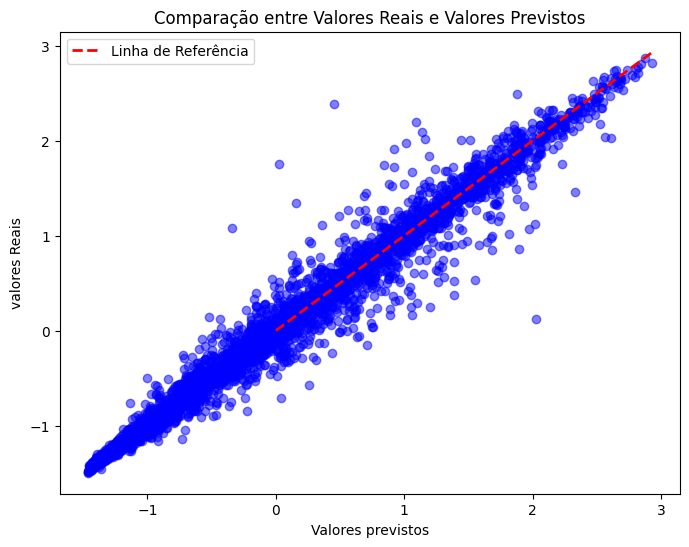

In [17]:
plot_comparacao(histeresis_test_tensor,previstos_h)

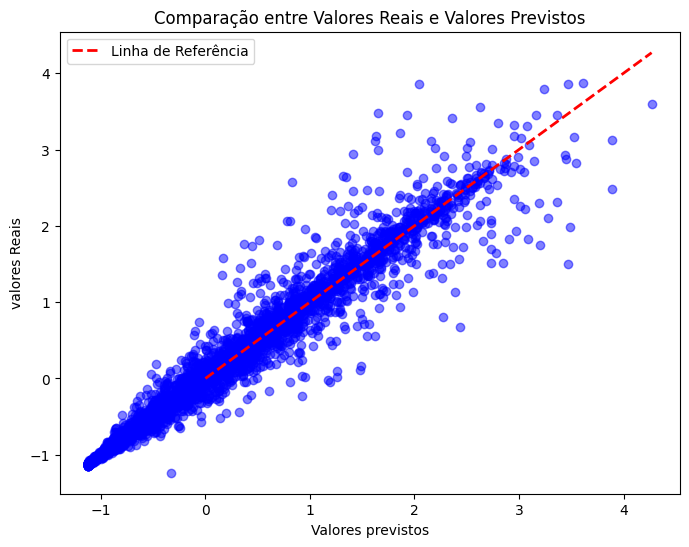

In [18]:
plot_comparacao(joule_test_tensor,previstos_j)

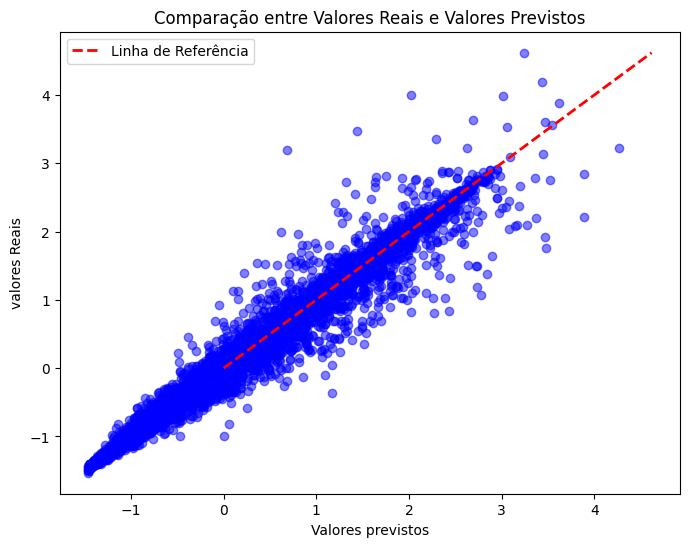

In [19]:
plot_comparacao(y_test_tensor,previstos_t)

In [20]:
mse_h = mean_squared_error(histeresis_test_tensor, previstos_h)
mae_h = mean_absolute_error(histeresis_test_tensor, previstos_h)
histeresis_test_np = histeresis_test_tensor.numpy()
previstos_np_h = previstos_h.numpy()
mape_h = np.mean(np.abs((histeresis_test_np - previstos_np_h) / histeresis_test_np)) * 100

mse_j = mean_squared_error(joule_test_tensor, previstos_j)
mae_j = mean_absolute_error(joule_test_tensor, previstos_j)
joule_test_np = joule_test_tensor.numpy()
previstos_np_j = previstos_j.numpy()
mape_j = np.mean(np.abs((joule_test_np - previstos_np_j) / joule_test_np)) * 100

mse_t = mean_squared_error(y_test_tensor, previstos_t)
mae_t = mean_absolute_error(y_test_tensor, previstos_t)
total_test_np = y_test_tensor.numpy()
previstos_np_t = previstos_t.numpy()
mape_t = np.mean(np.abs((total_test_np - previstos_np_t) / total_test_np)) * 100

print(f'Nabla histeresis model:')
print(f'Test MSE: {mse_h}')
print(f'Test MAE: {mae_h}')
print(f'Test MAPE: {mape_h}%')

print(f'Nabla joule model:')
print(f'Test MSE: {mse_j}')
print(f'Test MAE: {mae_j}')
print(f'Test MAPE: {mape_j}%')

print(f'Nabla total model:')
print(f'Test MSE: {mse_t}')
print(f'Test MAE: {mae_t}')
print(f'Test MAPE: {mape_t}%')

Nabla histeresis model:
Test MSE: 0.02707846648991108
Test MAE: 0.09427930414676666
Test MAPE: 79.8889696598053%
Nabla joule model:
Test MSE: 0.04630521312355995
Test MAE: 0.10548154264688492
Test MAPE: 103.59400510787964%
Nabla total model:
Test MSE: 0.03296629339456558
Test MAE: 0.09376008808612823
Test MAPE: 93.28341484069824%
